In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install librosa
!pip install soundfile
!pip install pydub

In [ ]:
import numpy as np
import librosa.display, os
import matplotlib.pyplot as plt
%matplotlib inline

from pydub import AudioSegment
from pydub.exceptions import CouldntDecodeError

In [ ]:
for i in os.listdir('/content/drive/MyDrive/web projects/audio'):
    if not os.path.exists(os.path.join('/content/drive/MyDrive/web projects/spectrograms', i)):
        os.makedirs(os.path.join('/content/drive/MyDrive/web projects/spectrograms', i))

In [ ]:
def convert_to_wav(input_file, output_file):
    """
    Convert audio file to .wav format.

    Args:
        input_file (str): Path to the input audio file.
        output_file (str): Path to save the output .wav file.
    """
    try:
        sound = AudioSegment.from_file(input_file)
        sound.export(output_file, format="wav")
        return output_file
    except CouldntDecodeError:
        print(f"Error: Could not decode {input_file}")

def create_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file, format = 'png')
    print("fig saved to", image_file)
    plt.close(fig)

def create_pngs_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # dir = os.listdir(input_path)


    # Iterate through each subdirectory in the input_path directory
    for animal_dir in os.listdir(input_path):
        animal_path = os.path.join(input_path, animal_dir)

        # Check if the item is a directory
        if os.path.isdir(animal_path):
            # Iterate through files in the animal's directory
            for file in os.listdir(animal_path):
                if file.endswith('.wav'):
                    input_file = os.path.join(animal_path, file)
                    output_file = os.path.join(output_path, animal_dir, file.replace('.wav', '.png'))
                    create_spectrogram(input_file, output_file)
                elif file.endswith('.mp3'):
                    input_file = os.path.join(animal_path, file)
                    print(input_file)
                    a = convert_to_wav(input_file,os.path.join(animal_path, file.replace('.mp3', '.wav')))
                    print(a.replace('.wav', '.png'))
                    output_file = os.path.join(output_path, animal_dir, os.path.basename(a).replace('.wav', '.png'))
                    create_spectrogram(input_file, output_file)


In [ ]:
create_pngs_from_wavs('/content/drive/MyDrive/web projects/audio', '/content/drive/MyDrive/web projects/spectrograms')

In [ ]:
from keras.preprocessing import image

def load_images_from_path(path, label):
    images = []
    labels = []

    for file in os.listdir(path):
        images.append(image.img_to_array(image.load_img(os.path.join(path, file), target_size=(224, 224, 3))))
        labels.append((label))

    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)

x = []
y = []

In [ ]:
for i in os.listdir("/content/drive/MyDrive/web projects/spectrograms"):
    print(len(os.listdir(os.path.join('/content/drive/MyDrive/web projects/spectrograms',i))))


In [ ]:
import os
from sklearn.model_selection import train_test_split
import shutil

# Path to the root directory containing your data
root_dir = '/content/drive/MyDrive/web projects/spectrograms'

# List all subdirectories (each subdirectory represents a class)
classes = os.listdir(root_dir)

# Create directories for train and test data
train_dir = '/content/TrainData'
test_dir = '/content/TestData'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterate over each class
for class_name in classes:
    class_dir = os.path.join(root_dir, class_name)

    # List all files in the current class directory
    files = os.listdir(class_dir)

    # Split the files into train and test sets
    train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)

    # Create subdirectories for the current class in train and test directories
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Move train files to train directory
    for file in train_files:
        src = os.path.join(class_dir, file)
        dest = os.path.join(train_dir, class_name, file)
        shutil.copy(src, dest)

    # Move test files to test directory
    for file in test_files:
        src = os.path.join(class_dir, file)
        dest = os.path.join(test_dir, class_name, file)
        shutil.copy(src, dest)

print("Data split into train and test sets.")


Data split into train and test sets.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D

# Example paths to your dataset
train_dir = '/content/TrainData'
validation_dir = '/content/TestData'

# Define image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 32

# Create an ImageDataGenerator instance with data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values
    rotation_range=40,         # Randomly rotate images (0-40 degrees)
    width_shift_range=0.2,     # Randomly shift images horizontally
    height_shift_range=0.2,    # Randomly shift images vertically
    shear_range=0.2,           # Shear transformations
    zoom_range=0.2,            # Randomly zoom images
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Fill in missing pixels after transformations
)

# Validation data should not be augmented
validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen
train_generator = train_datagen.flow_from_directory(
    train_dir,                 # Directory with training images
    target_size=(img_width, img_height),  # Resize images to specified dimensions
    batch_size=batch_size,     # Batch size
    class_mode='categorical'        # For binary classification
)

# Flow validation images in batches using validation_datagen
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,            # Directory with validation images
    target_size=(img_width, img_height),  # Resize images to specified dimensions
    batch_size=batch_size,     # Batch size
    class_mode='categorical'        # For binary classification
)

# Create a simple CNN model
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
#     MaxPooling2D((2, 2)),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(512, activation='relu'),
#     Dense(21, activation='softmax')
# ])

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(21, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Found 3113 images belonging to 21 classes.
Found 790 images belonging to 21 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 128)     36992     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 128)       147584    
                                   

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Assuming you have trained your model and obtained predictions on validation data
# Example:
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Example true labels (replace this with actual true labels)
true_labels = validation_generator.classes

# Generate classification report
report = classification_report(true_labels, predicted_classes, target_names=validation_generator.class_indices.keys())
print("Classification Report:")
print(report)

# Generate confusion matrix
conf_mat = confusion_matrix(true_labels, predicted_classes)
print("\nConfusion Matrix:")
print(conf_mat)


25/25 [==============================] - 7s 268ms/step
Classification Report:
              precision    recall  f1-score   support

       Alces       0.09      0.08      0.08        25
         Bat       0.05      0.07      0.06        15
        Bear       0.04      0.03      0.03        35
     Cheetah       0.00      0.00      0.00        24
   Crocodile       0.00      0.00      0.00        23
        Deer       0.08      0.08      0.08        49
    Elephant       0.05      0.06      0.05        54
      Ferret       0.00      0.00      0.00        16
         Fox       0.03      0.04      0.04        26
        Frog       0.00      0.00      0.00        19
       Gecko       0.00      0.00      0.00        19
     Insects       0.12      0.12      0.12       114
     Leopard       0.00      0.00      0.00        24
        Lion       0.00      0.00      0.00        27
    Mongoose       0.09      0.07      0.08        29
      Monkey       0.03      0.04      0.03        26
   

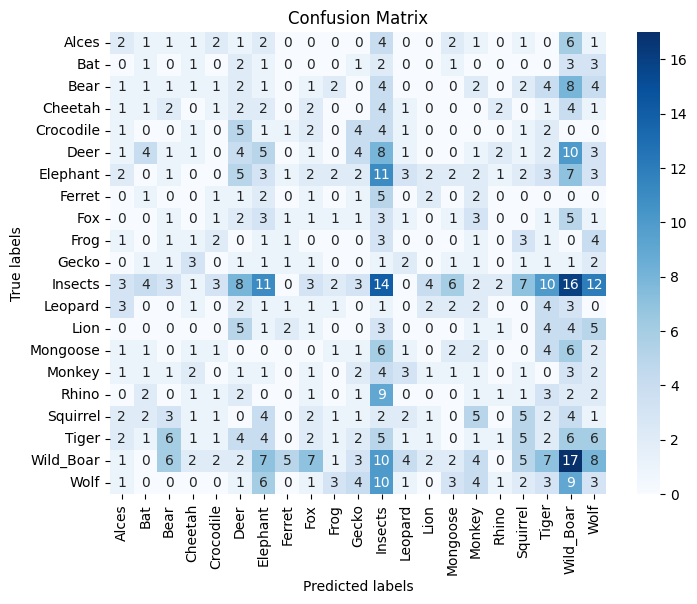

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=validation_generator.class_indices.keys(),
            yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Assuming you have already trained your model and assigned it to the variable 'model'

# Define the path where you want to save your model
model_save_path = '/content/model.keras'

# Save the model
model.save(model_save_path)

print("Model saved successfully.")

Model saved successfully.


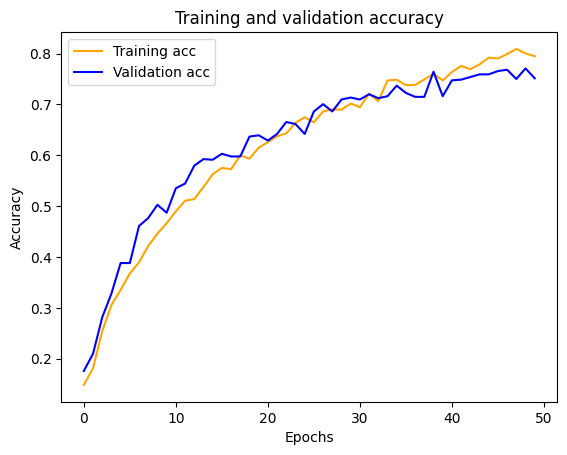

In [ ]:
# prompt: plot the training validation accuracy from above model

# Extract the training and validation accuracy from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Get the number of epochs
epochs = range(len(acc))

# Plot the training and validation accuracy
plt.figure()
plt.plot(epochs, acc, color = 'orange', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


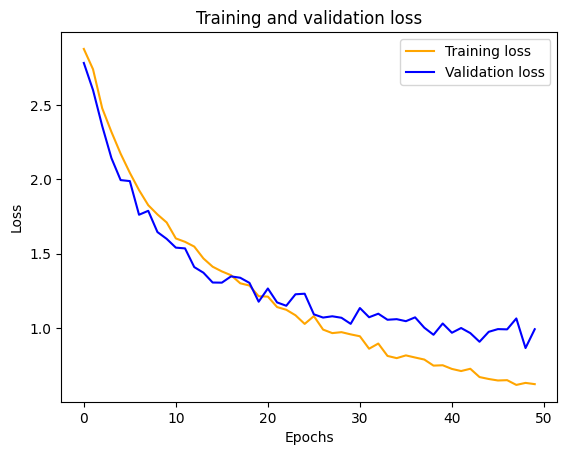

In [ ]:
# prompt: Training and validation loss

# Extract the training and validation loss from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs
epochs = range(len(loss))

# Plot the training and validation loss
plt.figure()
plt.plot(epochs, loss, color = 'orange', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
#  Freeze the pre-trained layers to avoid retraining them
from tensorflow.keras.models import Model
base_model.trainable = False

# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a classification layer with your desired number of classes (21 in this case)
predictions = Dense(21, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [ ]:
# print(train_features.shape[1:])
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

(7, 7, 1280)
Epoch 1/50
97/97 [==============================] - 71s 707ms/step - loss: 2.3289 - accuracy: 0.3350 - val_loss: 1.9353 - val_accuracy: 0.4193
Epoch 2/50
97/97 [==============================] - 68s 698ms/step - loss: 1.6978 - accuracy: 0.4982 - val_loss: 1.6885 - val_accuracy: 0.5052
Epoch 3/50
97/97 [==============================] - 72s 738ms/step - loss: 1.4541 - accuracy: 0.5716 - val_loss: 1.5770 - val_accuracy: 0.5391
Epoch 4/50
97/97 [==============================] - 68s 698ms/step - loss: 1.3615 - accuracy: 0.6014 - val_loss: 1.4611 - val_accuracy: 0.5638
Epoch 5/50
97/97 [==============================] - 67s 687ms/step - loss: 1.2828 - accuracy: 0.6157 - val_loss: 1.4326 - val_accuracy: 0.5781
Epoch 6/50
97/97 [==============================] - 66s 682ms/step - loss: 1.2110 - accuracy: 0.6410 - val_loss: 1.3576 - val_accuracy: 0.6094
Epoch 7/50
97/97 [==============================] - 65s 667ms/step - loss: 1.1435 - accuracy: 0.6592 - val_loss: 1.3385 - val_acc